# MNIST digits classification with TensorFlow

<img src="https://github.com/hse-aml/intro-to-dl/blob/master/week2/v2/images/mnist_sample.png?raw=1" style="width:30%">

In [2]:
! shred -u setup_google_colab.py
! wget https://raw.githubusercontent.com/hse-aml/intro-to-dl/master/setup_google_colab.py -O setup_google_colab.py
import setup_google_colab
# please, uncomment the week you're working on
# setup_google_colab.setup_week1()
setup_google_colab.setup_week2()
# setup_google_colab.setup_week3()
# setup_google_colab.setup_week4()
# setup_google_colab.setup_week5()
# setup_google_colab.setup_week6()

# If you're using the old version of the course (check a path of notebook on Coursera, you'll see v1 or v2),
# use setup_week2_old().

shred: setup_google_colab.py: failed to open for writing: No such file or directory
--2018-12-24 22:00:47--  https://raw.githubusercontent.com/hse-aml/intro-to-dl/master/setup_google_colab.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3792 (3.7K) [text/plain]
Saving to: ‘setup_google_colab.py’

setup_google_colab. 100%[===================>]   3.70K  --.-KB/s    in 0s      

2018-12-24 22:00:48 (67.9 MB/s) - ‘setup_google_colab.py’ saved [3792/3792]

**************************************************
inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5
**************************************************
cifar-10-batches-py.tar.gz
**************************************************
mnist.npz


In [4]:
import numpy as np
from sklearn.metrics import accuracy_score
from matplotlib import pyplot as plt
%matplotlib inline
import tensorflow as tf
print("We're using TF", tf.__version__)

import sys
sys.path.append("../..")
import grading

import matplotlib_utils
from importlib import reload
reload(matplotlib_utils)

import grading_utils
reload(grading_utils)

import keras_utils
from keras_utils import reset_tf_session

We're using TF 1.12.0


# Fill in your Coursera token and email
To successfully submit your answers to our grader, please fill in your Coursera submission token and email

In [0]:
grader = grading.Grader(assignment_key="XtD7ho3TEeiHQBLWejjYAA", 
                        all_parts=["9XaAS", "vmogZ", "RMv95", "i8bgs", "rE763"])

In [0]:
# token expires every 30 min
COURSERA_TOKEN = "1NBdD2OCV46xVvaG"
COURSERA_EMAIL = "eng_walid_ashraf@hotmail.com"

# Look at the data

In this task we have 50000 28x28 images of digits from 0 to 9.
We will train a classifier on this data.

In [0]:
import preprocessed_mnist
X_train, y_train, X_val, y_val, X_test, y_test = preprocessed_mnist.load_dataset()

X_train [shape (50000, 28, 28)] sample patch:
 [[0.         0.29803922 0.96470588 0.98823529 0.43921569]
 [0.         0.33333333 0.98823529 0.90196078 0.09803922]
 [0.         0.33333333 0.98823529 0.8745098  0.        ]
 [0.         0.33333333 0.98823529 0.56862745 0.        ]
 [0.         0.3372549  0.99215686 0.88235294 0.        ]]
A closeup of a sample patch:


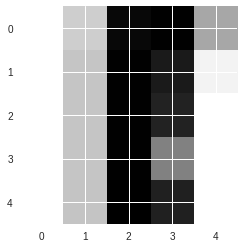

And the whole sample:


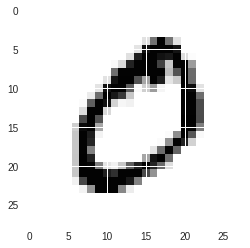

y_train [shape (50000,)] 10 samples:
 [5 0 4 1 9 2 1 3 1 4]


In [81]:
# X contains rgb values divided by 255
print("X_train [shape %s] sample patch:\n" % (str(X_train.shape)), X_train[1, 15:20, 5:10])
print("A closeup of a sample patch:")
plt.imshow(X_train[1, 15:20, 5:10], cmap="Greys")
plt.show()
print("And the whole sample:")
plt.imshow(X_train[1], cmap="Greys")
plt.show()
print("y_train [shape %s] 10 samples:\n" % (str(y_train.shape)), y_train[:10])

# Linear model

Your task is to train a linear classifier $\vec{x} \rightarrow y$ with SGD using TensorFlow.

You will need to calculate a logit (a linear transformation) $z_k$ for each class: 
$$z_k = \vec{x} \cdot \vec{w_k} + b_k \quad k = 0..9$$

And transform logits $z_k$ to valid probabilities $p_k$ with softmax: 
$$p_k = \frac{e^{z_k}}{\sum_{i=0}^{9}{e^{z_i}}} \quad k = 0..9$$

We will use a cross-entropy loss to train our multi-class classifier:
$$\text{cross-entropy}(y, p) = -\sum_{k=0}^{9}{\log(p_k)[y = k]}$$ 

where 
$$
[x]=\begin{cases}
       1, \quad \text{if $x$ is true} \\
       0, \quad \text{otherwise}
    \end{cases}
$$

Cross-entropy minimization pushes $p_k$ close to 1 when $y = k$, which is what we want.

Here's the plan:
* Flatten the images (28x28 -> 784) with `X_train.reshape((X_train.shape[0], -1))` to simplify our linear model implementation
* Use a matrix placeholder for flattened `X_train`
* Convert `y_train` to one-hot encoded vectors that are needed for cross-entropy
* Use a shared variable `W` for all weights (a column $\vec{w_k}$ per class) and `b` for all biases.
* Aim for ~0.93 validation accuracy

In [82]:
X_train_flat = X_train.reshape((X_train.shape[0], -1))
print(X_train_flat.shape)

X_val_flat = X_val.reshape((X_val.shape[0], -1))
print(X_val_flat.shape)

(50000, 784)
(10000, 784)


In [83]:
import keras

y_train_oh = keras.utils.to_categorical(y_train, 10)
y_val_oh = keras.utils.to_categorical(y_val, 10)

print(y_train_oh.shape)
print(y_train_oh[:3], y_train[:3])

(50000, 10)
[[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]] [5 0 4]


In [0]:
# run this again if you remake your graph
s = reset_tf_session()

In [0]:
# Model parameters: W and b
W = tf.Variable(tf.random_normal(shape=[784, 10], stddev=0.01), name="weights")
#tf.get_variable("w",shape=(784,10), dtype=tf.float64)### YOUR CODE HERE ### tf.get_variable(...) with shape[0] = 784
b =  tf.Variable(tf.zeros([1, 10]), name="bias")
#tf.get_variable("b",shape=(1,10), dtype=tf.float64)### YOUR CODE HERE ### tf.get_variable(...)

In [0]:
# Placeholders for the input data
input_X = tf.placeholder('float32', shape=[None,784])### YOUR CODE HERE ### tf.placeholder(...) for flat X with shape[0] = None for any batch size
input_y = tf.placeholder('float32', shape=[None,10])### YOUR CODE HERE ### tf.placeholder(...) for one-hot encoded true labels

In [0]:
# Compute predictions
logits = tf.matmul(input_X, W) + b### YOUR CODE HERE ### logits for input_X, resulting shape should be [input_X.shape[0], 10]
probas = tf.nn.softmax(logits)### YOUR CODE HERE ### apply tf.nn.softmax to logits
classes = tf.argmax(probas,axis=1)### YOUR CODE HERE ### apply tf.argmax to find a class index with highest probability

# Loss should be a scalar number: average loss over all the objects with tf.reduce_mean().
# Use tf.nn.softmax_cross_entropy_with_logits on top of one-hot encoded input_y and logits.
# It is identical to calculating cross-entropy on top of probas, but is more numerically friendly (read the docs).
loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(labels=input_y,logits=logits))### YOUR CODE HERE ### cross-entropy loss

# Use a default tf.train.AdamOptimizer to get an SGD step
step = tf.train.GradientDescentOptimizer(0.1).minimize(loss)### YOUR CODE HERE ### optimizer step that minimizes the loss

In [158]:
s.run(tf.global_variables_initializer())

BATCH_SIZE = 512
EPOCHS = 40

# for logging the progress right here in Jupyter (for those who don't have TensorBoard)
simpleTrainingCurves = matplotlib_utils.SimpleTrainingCurves("cross-entropy", "accuracy")

for epoch in range(EPOCHS):  # we finish an epoch when we've looked at all training samples
    
    batch_losses = []
    for batch_start in range(0, X_train_flat.shape[0], BATCH_SIZE):  # data is already shuffled
        _, batch_loss = s.run([step, loss], {input_X: X_train_flat[batch_start:batch_start+BATCH_SIZE], 
                                             input_y: y_train_oh[batch_start:batch_start+BATCH_SIZE]})
        # collect batch losses, this is almost free as we need a forward pass for backprop anyway
        batch_losses.append(batch_loss)

    train_loss = np.mean(batch_losses)
    val_loss = s.run(loss, {input_X: X_val_flat, input_y: y_val_oh})  # this part is usually small
    train_accuracy = accuracy_score(y_train, s.run(classes, {input_X: X_train_flat}))  # this is slow and usually skipped
    valid_accuracy = accuracy_score(y_val, s.run(classes, {input_X: X_val_flat}))  
    simpleTrainingCurves.add(train_loss, val_loss, train_accuracy, valid_accuracy)

<img src="%2BTl5ufo6erx8vP09fb3%2BPn6/8QAHwEAAwEBAQEBAQEBAQAAAAAAAAECAwQFBgcICQoL/8QAtREAAgECBAQDBAcFBAQAAQJ3AAECAxEEBSExBhJBUQdhcRMiMoEIFEKRobHBCSMzUvAVYnLRChYkNOEl8RcYGRomJygpKjU2Nzg5OkNERUZHSElKU1RVVldYWVpjZGVmZ2hpanN0dXZ3eHl6goOEhYaHiImKkpOUlZaXmJmaoqOkpaanqKmqsrO0tba3uLm6wsPExcbHyMnK0tPU1dbX2Nna4uPk5ebn6Onq8vP09fb3%2BPn6/9oADAMBAAIRAxEAPwD9/KKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAoorL0Txv4L8Tazq3hzw34v0vUNQ0G4S31ywsdQjlm06V4xIkc6KxaFmRlcK4BKsCODmgDUornvA/xc%2BFHxNvdU034bfE7w94hudDufs%2BtW%2Bh61Bdvp82WHlzrE7GJ8o42tg5RvQ10NABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQB4n4u/4KKfsfeBNQvNP8V/FS5tBZ6o2mi8PhTVHtLy8W/h0%2BS3tLhLYw3skd3PFBItu8hidiH27WxtH9s/8AZ0j8c2Xw5uvGOo2%2BqXl1YWbLd%2BFNTht7K9vYo5bSxu7h7YQ2N5KksRW0uHjnJmjHl5dQfErn9jP9q2PwF4b/AGddM1P4ejwL4T%2BLem%2BK7bWrnUb19V1Wzt/F1rrYt5IBaiK1ljgS4i3iWYXEixE/Z1ZtvQ%2BOP2PvjZrvjHxb4H0XU/C3/CAeOfi9oPj3VdautSuV1nT30%2BTSp5LCK1W3aGYSy6TFtuGuIzElww8pzGpYA9Ctf26v2X7uDV74eP76Gz0bT7m9l1K88KanBaXsFvOlvM9jcSWyxajtmkjjxatMS0iAA71z2fwp%2BMvgL406Te6v4EudTxpuoGy1Kz1vw9e6VeWk4jSXZLa30MM8eY5Y3UsgDK4IJBzXzNpv7EHx8tdW8TWtp4S%2BHGm%2BGNZ0HU7bVvAq%2BMtavvDvim8uLuCWO4bTJ4BHoDBEuCXs5Jz5lyGIl8obvQP2cf2TfHXhjTLn/hdvjLxDDBY%2BK11PwX4Z0P4yeIdSg0W2FvbK1tNfTNazanC88Mkoguo3iiWUxqChOQDpIv28f2VJo/EF0PibKtr4b0TVdXvtRl8O6glpdWWmki/msrhrcRakLcjEgtGmKkgEZIzzfjv/AIKX/sy%2BEPCsvibR7vxNrjweIvDemS6bp/gbV/tTxa3fizs7%2BGJrQPc2rlZ2jnhDxzNCYomeV40bxTQ/%2BCWPxH0b4Na58EvL0S6/s34b%2BKPDngXxXq3xX8TX5ebUbKeytpH0mfNjpaiGYrMYBcZIzGkfAHefH/8AYh%2BNnjvxw/xD%2BH2p%2BFHudP8ADnw5i0nTtX1O5to7m%2B8N%2BKJtZnilkitpTDDLE6RJKqSMHLExYA3AHqr/ALc/7Mi22vXcfjfU5k8N%2BJP%2BEe1IW3g/VZWfV/OeE6dbqlqTeXYdCTBAJJAhWQrsZWNTVP8AgoL%2ByhpNpo08nj/VbqfX7LVbrTNL0vwTrF5fsmmXEVvqCyWcFo9xDLbyzIskUkayJ8xK4RyvC237HXxp0LwtaeINCvvCs3ivQP2hNZ%2BI%2BjaZdancx6ffQXy6hbmznuVtmkhkFtqMpEiwyhZYk%2BVhXmGkfCP9pb4L/tzeENU8H6b4G1fx34p8B/EvxLrGkanrt5a6Ra/bNb8LhLeC7SzlmbylW3zIbdfOKy/LF5g2gH1HY/tkfs06p4M1n4haV8Ure70fQbjSYNQvbSxuZQW1SG0m08wqsZa5W4S%2BtfLeEOrNIUzuR1X02vgb4bfsh2vgj9qz4K/s7eCviXYa7YfDz4Z6K/xvs7NOHvdAXd4eeVVJFtJLdajPcpG/ztFp0eMqgNffNABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABXm3xV/a6/Z%2B%2BCfjKPwH8SfG9xZaj9ltLq8%2Bz6DfXdvptvdXD21tPe3FvA8NhFLNHIiSXLxqxjfBOxsek18h/t4/sVftR/tSaz4z0bwj8QtP8A%2BEc13whaWfhi21D4g61pUGjX0LzyTefp2nxeRqcdyxgUy3MjeQqkrBLt2OAewQ/t1/sqSXet203xVW1i0DT9QvrvUNQ0W9trK5t7CZYL2SzupYVh1AQyukb/AGV5SruqnlgDoeBP2wP2ffiP4k07wX4a8YX0et6pqd1p9voer%2BGdR06%2Biube0jvJY57e7t45bY/ZpY5l85UEiSKULZFeGaH%2Bxr%2B1refsrn9kLxBrXw80rQNF0iT%2BwNasr%2B%2B1C71C%2Bi1KG%2BsBco9vbrbQxmIxTlGna43B1EHMZ6/xj8Jf20/GvxA8D/HrVND%2BGCa/4M8S6hJaeDoPE2oLZjTLvS/sjltTNgZJrgTjzgPscaeWfKzlfNYA7XQ/26f2WvEuu2HhzQ/iXLcXWo6FPrUWzw9qAih02Ge5t5ryeUweXawJNaTxtJMyKGCAn97Fvb4e/bs/Zd8TeE9d8a2XxCvbay8O2On3upR6v4V1OwuWtr%2BRorGaC2ubaOa7juZVaKBoEkE0gKRlm%2BWvHf2fP2Ef2lfgx4b1d4vij4XsfFFx8E7vwro/iLS45pVsdak1bVr6K9EMsQBgT7dbttLE7o3XBADNyVj/AME5v2o7jxpqPxE1DXfDsV/Po3hGezt9a%2BKev%2BJGGseHde/taFZbnULYP9lu98qP5KRLana0cExLGgD6g%2BHv7YX7O3xP12Xwv4U8fyLqdtpd7qF7pur6Je6bcWcFnLFFdefHdwxNA8TXFuXikCyKs8TldkiMe0%2BHvj3wt8VPAWifE3wNfyXei%2BItJt9S0i6ms5bdprWeNZYnMUypJGSjKdrqrDOCAeK%2BOP24/h78Z/jDbfDn4e%2BMPGPhDQ/il4q8aahosfh7wfe3F08PgfUrJrTWl86VIZZjFCiXZuzDBGJ4baILuKGT7Z07TrDSNPg0nS7OO3tbWFYba3hQKkUagBVUDgAAAAe1AE1FFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFfNv7OHiPwd4W/au%2BMGlaH8LPF2i2Ov6zp02n3bfC7WLLT724WBlvJhcvZpAxa4d2aQviQszgsCWr6SooA%2Ba/2I7nRvHfjvWfi1/wrHxD4Hc%2BGbLQPCngbUPhzqmhW%2BheH7SadreN3urWGGW6kaYu8UJKQII4kB2SSy/QviLW/7BskvPsvm7pQm3ftxkE5zg%2BlX68t%2BMnxYfQvjP4P%2BCbaUjR%2BJvDut6uL4ykNE%2BnzabEIguMEOuoOxOePJAwd3Cc4QkufZtL5vRHThcJiMbKUaKu4xlN/4YR5pP5LW276HVf8LJ/6gv8A5M//AGNH/Cyf%2BoL/AOTP/wBjXL0V2%2Byp9jjuzqP%2BFk/9QX/yZ/8AsaP%2BFk/9QX/

# Submit a linear model

In [142]:
## GRADED PART, DO NOT CHANGE!
# Testing shapes 
grader.set_answer("9XaAS", grading_utils.get_tensors_shapes_string([W, b, input_X, input_y, logits, probas, classes]))
# Validation loss
grader.set_answer("vmogZ", s.run(loss, {input_X: X_val_flat, input_y: y_val_oh}))
# Validation accuracy
grader.set_answer("RMv95", accuracy_score(y_val, s.run(classes, {input_X: X_val_flat})))

FailedPreconditionError: ignored

In [132]:
# you can make submission with answers so far to check yourself at this stage
grader.submit(COURSERA_EMAIL, COURSERA_TOKEN)

Submitted to Coursera platform. See results on assignment page!


# MLP with hidden layers

Previously we've coded a dense layer with matrix multiplication by hand. 
But this is not convenient, you have to create a lot of variables and your code becomes a mess. 
In TensorFlow there's an easier way to make a dense layer:
```python
hidden1 = tf.layers.dense(inputs, 256, activation=tf.nn.sigmoid)
```

That will create all the necessary variables automatically.
Here you can also choose an activation function (remember that we need it for a hidden layer!).

Now define the MLP with 2 hidden layers and restart training with the cell above.

You're aiming for ~0.97 validation accuracy here.

In [0]:
# write the code here to get a new `step` operation and then run the cell with training loop above.
# name your variables in the same way (e.g. logits, probas, classes, etc) for safety.
### YOUR CODE HERE ###
hidden1 = tf.layers.dense(input_X, 256, activation=tf.nn.sigmoid)

hidden2 = tf.layers.dense(hidden1, 256, activation=tf.nn.sigmoid)

logits = tf.layers.dense(hidden2, 10)

probas = tf.nn.softmax(logits)

classes = tf.argmax(probas, 1)

loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits = logits, labels = input_y))

step = tf.train.AdamOptimizer().minimize(loss)

# Submit the MLP with 2 hidden layers
Run these cells after training the MLP with 2 hidden layers

In [0]:
## GRADED PART, DO NOT CHANGE!
# Validation loss for MLP
grader.set_answer("i8bgs", s.run(loss, {input_X: X_val_flat, input_y: y_val_oh}))
# Validation accuracy for MLP
grader.set_answer("rE763", accuracy_score(y_val, s.run(classes, {input_X: X_val_flat})))

In [160]:
# you can make submission with answers so far to check yourself at this stage
grader.submit(COURSERA_EMAIL, COURSERA_TOKEN)

Submitted to Coursera platform. See results on assignment page!
